In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

In [2]:
aaplX = pd.read_csv('aaplDF-q2.csv')
aaplX = aaplX.loc[:, aaplX.columns != 'date']
aaplX = aaplX.loc[:, aaplX.columns != 'Unnamed: 0']
aaplX = aaplX.loc[:, aaplX.columns != 'daychange']
aaplX = aaplX.loc[:, aaplX.columns != 'anger']
aaplX = aaplX.loc[:, aaplX.columns != 'disgust']
aaplX = aaplX.loc[:, aaplX.columns != 'fear']
aaplX = aaplX.loc[:, aaplX.columns != 'joy']
aaplX = aaplX.loc[:, aaplX.columns != 'sadness']
aaplX = aaplX.loc[:, aaplX.columns != 'surprise']
aaplX = aaplX.loc[:, aaplX.columns != 'connectivity']
aaplX = aaplX.loc[:, aaplX.columns != 'avgdeg']

aaplX = aaplX.head(70)
aaplX

,size,edges,diameter,clustering,volume
0,917,848,10,0.000458,143301900
1,750,662,19,0.000687,97664900
2,851,741,16,0.000113,155088000
3,832,722,12,0.000000,109578200
4,1442,1356,13,0.000483,105158200
...,...,...,...,...,...
65,915,859,14,0.000151,88844600
66,820,782,11,0.000050,106686700
67,835,776,15,0.000181,91420000
68,1078,1043,13,0.000114,91266500


<Axes: >

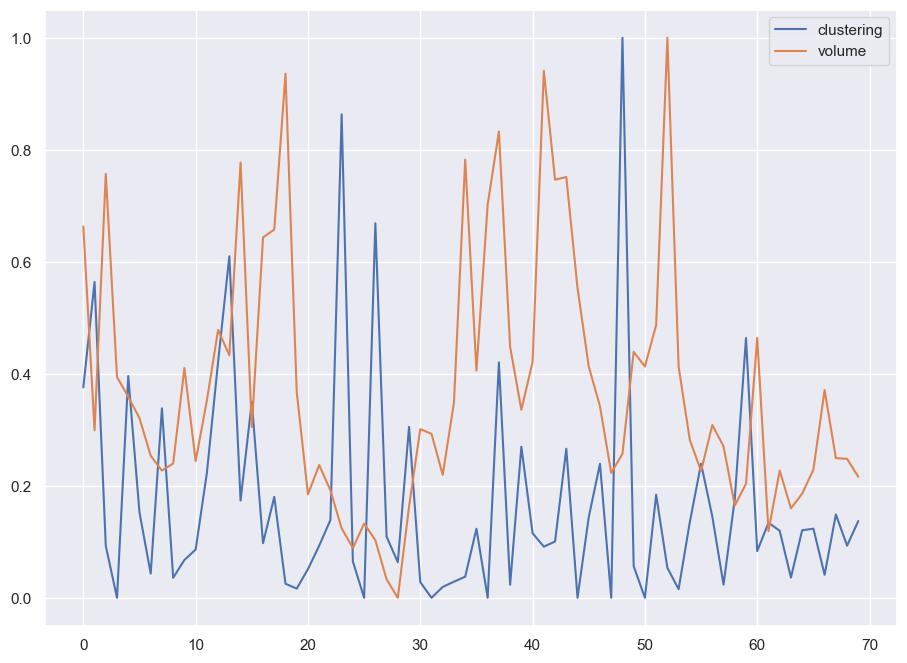

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
sns.set(rc={'figure.figsize':(11,8)})

aaplXs = scaler.fit_transform(aaplX)
aaplXs = pd.DataFrame(aaplXs,columns=['size','edges','diameter','clustering','volume'])
aaplXs[['clustering','volume']].plot()

In [4]:
for metric in aaplXs.columns:
    result = adfuller(aaplXs[[metric]])
    print('A-DF of metric',metric,'has p-value of',result[1])
    print()

A-DF of metric size has p-value of 0.016371385813761644

A-DF of metric edges has p-value of 0.012445164952402126

A-DF of metric diameter has p-value of 0.5600339563097199

A-DF of metric clustering has p-value of 4.358186671696678e-15

A-DF of metric volume has p-value of 7.858387707996878e-05



In [6]:
#build the VAR model
model = VAR(aaplXs)
print(model.select_order(5))

aapl_model = model.fit(1)

aapl_model.summary()

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 1, BIC -> 1, FPE -> 1, HQIC ->  1>


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 23, Oct, 2023
Time:                     10:44:10
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -23.4019
Nobs:                     69.0000    HQIC:                  -23.9879
Log likelihood:           381.343    FPE:                2.60494e-11
AIC:                     -24.3732    Det(Omega_mle):     1.71687e-11
--------------------------------------------------------------------
Results for equation size
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.003252         0.035591            0.091           0.927
L1.size              -1.442848         1.777194           -0.812           0.417
L1.edges              2.188566         1.797949            1.

Text(0, 0.5, 'Volume (0,1)')

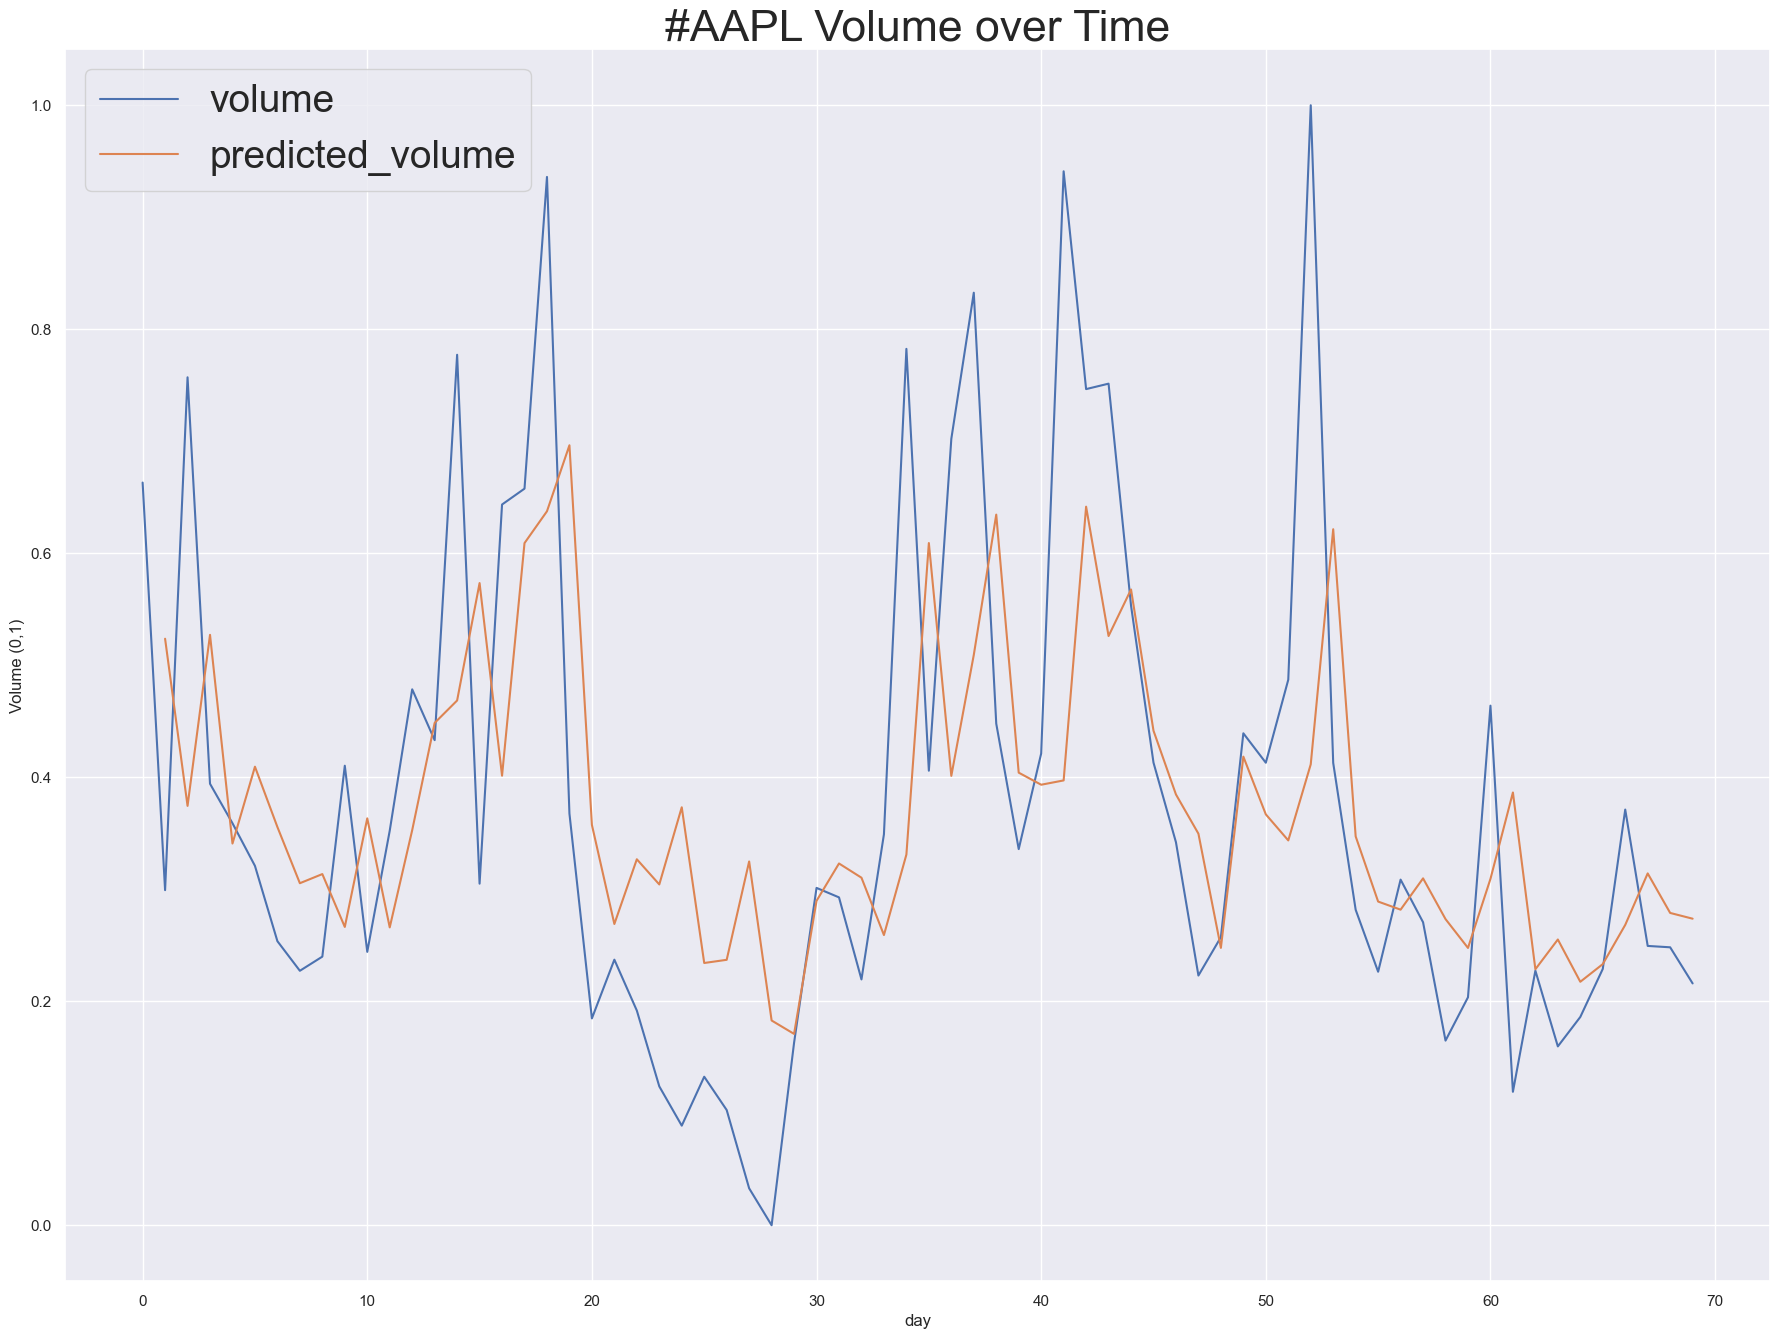

In [10]:
#forecast and plot

sns.set(rc={'figure.figsize':(22,16)})

aaplXs[['volume']].plot()
plt.plot(aapl_model.fittedvalues['volume'],label='predicted_volume')
plt.legend(fontsize='28')
plt.title('#AAPL Volume over Time',fontsize=32)
plt.xlabel('day')
plt.ylabel('Volume (0,1)')

In [11]:
#test for causality
print(aapl_model.test_causality(4,0))
print(aapl_model.test_causality(4,1))
print(aapl_model.test_causality(4,2))
print(aapl_model.test_causality(4,3))
print(aapl_model.test_causality(4,4))

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: size does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 0.302, critical value: 3.871>, p-value: 0.583>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: edges does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 0.246, critical value: 3.871>, p-value: 0.620>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: diameter does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 0.004, critical value: 3.871>, p-value: 0.949>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: clustering does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 1.639, critical value: 3.871>, p-value: 0.201>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: volu

In [13]:
print('AAPL',mean_absolute_error(aaplXs[['volume']][1:],aapl_model.fittedvalues['volume']))

AAPL 0.13991704440387642
